# Classification using neural networks

We study here the performance of feedforward neural networks to classify digits in the MNIST set. 

**There are 2 questions to answer.**

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# set up the random number generator: given seed for reproducibility, None otherwise
# (see https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng)
my_seed = 1
rng = np.random.default_rng(seed=my_seed) 

## Construction of the dataset 

We use the MNIST dataset already encountered in various hands-on sessions. We download it through PyTorch here (note: I had to run "jupyter nbextension enable --py widgetsnbextension" in the command line for this to work; maybe also "pip3 install --upgrade ipywidgets").

In [2]:
full_train_dataset = torchvision.datasets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor(),download=True)

We first explore the format of the dataset.

In [4]:
print(full_train_dataset)
print("\nformat of train data:",full_train_dataset.data.dtype)
print(test_dataset)
print("\nformat of test data:",test_dataset.data.dtype)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

format of train data: torch.uint8
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

format of test data: torch.uint8


We next construct a training set and a validation set out of the full training set. In order to make the training faster, we can reduce the size of the dataset if we want.

In [5]:
reduced_length = 50000
validation_length = 10000
# check whether we go out of bounds in terms of use of training data points
assert(reduced_length+validation_length<=full_train_dataset.data.shape[0])
# we can then extract the corresponding indices
indices_train = range(reduced_length)
indices_validation = range(reduced_length,reduced_length+validation_length)
train_dataset = torch.utils.data.Subset(full_train_dataset, indices=indices_train)
validation_dataset = torch.utils.data.Subset(full_train_dataset, indices=indices_validation)

We can plot the first elements of the resulting data set in order to see what they looks like.

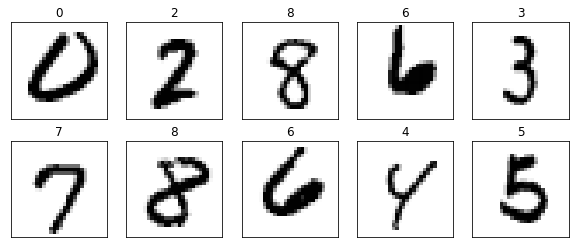

In [6]:
plt.figure(figsize=(10, 4))

picture_loader = torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=25,shuffle=True)
examples = iter(picture_loader)
example_data, example_labels = examples.next()

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # color map = binary, other choices here https://matplotlib.org/stable/tutorials/colors/colormaps.html
    plt.imshow(example_data[i][0].reshape(28,28), cmap=plt.cm.binary)     
    plt.title(example_labels[i].item())
plt.show()

## Introducing neural networks

We first introduce the class of neural networks we consider. Activation functions and topology can be modified.

In [7]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
         super(NeuralNet, self).__init__()
         self.input_size = input_size
         self.relu = nn.ReLU()
         self.layer_1 = nn.Linear(input_size, hidden_size)
         self.layer_2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
         out = self.layer_1(x)
         out = self.relu(out)
         out = self.layer_2(out)
         # no activation and no softmax at the end since the loss function requires only unnormalized logits
         return out

We next specify the parameters and loss function. See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for the cross entropy.

In [8]:
#--- construction of the model: from input_size to num_classes with one hidden layer --- 
input_size = 784
hidden_size = 50
num_classes = 10
model = NeuralNet(input_size, hidden_size, num_classes)

#--- Loss and optimizer ---
num_epochs = 30
batch_size = 60
learning_rate = 0.01 
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#--- data --- 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=validation_length,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=test_dataset.data.shape[0],shuffle=True)

We can check that the test and validation sets consist of a single batch.

In [9]:
for i, (images, labels) in enumerate(validation_loader):
    print('validation:',images.shape)
for i, (images, labels) in enumerate(test_loader):
    print('test:',images.shape)

validation: torch.Size([10000, 1, 28, 28])
test: torch.Size([10000, 1, 28, 28])


**Question 1.** Perform the training. What accuracy can you get?

In [10]:
early_stopping_steps = 10
min_validation_loss = 10000
nb_steps_where_test_loss_did_not_decrease = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
         # original shape [batch_size, 1, 28, 28], resized to [batch_size, 784]
         images = images.reshape(-1, 28*28)
         # Forward pass
         outputs = model(images)
         loss = loss_function(outputs, labels)
         # Backward and optimize
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
    # validation loss for early stopping
    nb_steps_where_test_loss_did_not_decrease += 1
    if (nb_steps_where_test_loss_did_not_decrease > early_stopping_steps):
        print('The test loss no longer decreases... STOP')
        break
    for j, (validation_images, validation_labels) in enumerate(validation_loader):
         validation_loss = loss_function(model(validation_images.reshape(-1, 28*28)),validation_labels)
    if (validation_loss < min_validation_loss):
        min_validation_loss = validation_loss
        nb_steps_where_test_loss_did_not_decrease = 0
        print(f'-- Better model // saving')
        torch.save(model, 'best_model')    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {loss.item():.4f}, Validation loss: {validation_loss.item():.4f}')

-- Better model // saving
Epoch [1/30], Train loss: 0.0786, Validation loss: 0.1453
-- Better model // saving
Epoch [2/30], Train loss: 0.0136, Validation loss: 0.1395
Epoch [3/30], Train loss: 0.0046, Validation loss: 0.1527
Epoch [4/30], Train loss: 0.1342, Validation loss: 0.1456
Epoch [5/30], Train loss: 0.0209, Validation loss: 0.1434
-- Better model // saving
Epoch [6/30], Train loss: 0.1318, Validation loss: 0.1317
Epoch [7/30], Train loss: 0.0016, Validation loss: 0.1484
Epoch [8/30], Train loss: 0.0210, Validation loss: 0.1840
Epoch [9/30], Train loss: 0.0009, Validation loss: 0.1696
Epoch [10/30], Train loss: 0.0197, Validation loss: 0.1971
Epoch [11/30], Train loss: 0.0014, Validation loss: 0.1851
Epoch [12/30], Train loss: 0.1079, Validation loss: 0.1888
Epoch [13/30], Train loss: 0.0466, Validation loss: 0.2084
Epoch [14/30], Train loss: 0.0737, Validation loss: 0.2222
Epoch [15/30], Train loss: 0.1144, Validation loss: 0.2489
Epoch [16/30], Train loss: 0.0000, Validation 

We can then test the quality of the predictions made by the network.

In [11]:
del model
model = torch.load('best_model')

# no gradient needed for evaluation
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 96.73 %


**Question 2.** Try to improve the performance by various means (adding an extra hidden layer, regularizing with dropout, changing the optimization algorithm, etc). What is the best test accuracy you can achieve?

In [12]:
# note: this could be made simpler with Sequential() to append layers in an automated manner
# see for instance the presentation in Section 6.1.2 of 
# http://preview.d2l.ai/d2l-en/master/chapter_builders-guide/model-construction.html
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes, dropout_proba, dropout_input):
         super(NeuralNet, self).__init__()
         self.input_size = input_size
         self.relu = nn.ReLU()
         self.dropout = nn.Dropout(dropout_proba)
         self.dropout_input = nn.Dropout(dropout_input)
         self.layer_1 = nn.Linear(input_size, hidden_size_1)
         self.layer_2 = nn.Linear(hidden_size_1, hidden_size_2) 
         self.layer_3 = nn.Linear(hidden_size_2, num_classes)
        
    def forward(self, x):
         out = self.dropout_input(x)
         out = self.layer_1(out)
         out = self.relu(out)
         out = self.dropout(out)
         out = self.layer_2(out)
         out = self.relu(out)
         out = self.dropout(out)
         out = self.layer_3(out)
         # still no activation at the end
         return out

In [13]:
#--- construction of the model: from input_size to num_classes with one hidden layer --- 
input_size = 784
hidden_size_1 = 50
hidden_size_2 = 20
num_classes = 10
dropout_proba = 0.1 # dropout rate on hidden nodes
dropout_input = 0. # dropout rate on input values
model = NeuralNet(input_size, hidden_size_1, hidden_size_2, num_classes, dropout_proba, dropout_input)

#--- Loss and optimizer ---
num_epochs = 30
batch_size = 100
learning_rate = 0.01
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # could be SGD instead of Adam here
early_stopping_steps = 5
min_validation_loss = 10000
nb_steps_where_test_loss_did_not_decrease = 0

#--- data --- 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=validation_length,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=test_dataset.data.shape[0],shuffle=True)

#------ actual training -----------
for epoch in range(num_epochs):
    model.train() # to go to train mode and perform dropout
    for i, (images, labels) in enumerate(train_loader):
         images = images.reshape(-1, 28*28)
         # Forward pass
         outputs = model(images)
         loss = loss_function(outputs, labels)
         # Backward and optimize
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
    # validation loss for early stopping
    model.eval() # to go to evaluation mode and not perform dropout
    nb_steps_where_test_loss_did_not_decrease += 1
    if (nb_steps_where_test_loss_did_not_decrease > early_stopping_steps):
        print('The test loss no longer decreases... STOP')
        break
    for j, (validation_images, validation_labels) in enumerate(validation_loader):
         validation_loss = loss_function(model(validation_images.reshape(-1, 28*28)),validation_labels)
    if (validation_loss < min_validation_loss):
        min_validation_loss = validation_loss
        nb_steps_where_test_loss_did_not_decrease = 0
        print(f'-- Better model // saving')
        torch.save(model, 'best_model')    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {loss.item():.4f}, Validation loss: {validation_loss.item():.4f}')

-- Better model // saving
Epoch [1/30], Train loss: 0.2017, Validation loss: 0.1787
-- Better model // saving
Epoch [2/30], Train loss: 0.1861, Validation loss: 0.1624
-- Better model // saving
Epoch [3/30], Train loss: 0.2336, Validation loss: 0.1421
Epoch [4/30], Train loss: 0.2626, Validation loss: 0.1526
-- Better model // saving
Epoch [5/30], Train loss: 0.2920, Validation loss: 0.1262
Epoch [6/30], Train loss: 0.1688, Validation loss: 0.1393
Epoch [7/30], Train loss: 0.0833, Validation loss: 0.1380
Epoch [8/30], Train loss: 0.1879, Validation loss: 0.1291
Epoch [9/30], Train loss: 0.3195, Validation loss: 0.1497
Epoch [10/30], Train loss: 0.2236, Validation loss: 0.1319
The test loss no longer decreases... STOP


In [14]:
del model
model = torch.load('best_model')
model.eval() 

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 96.27 %
